compare tasks (cookieTheft, picnicScene, journaling) to see which task's feature set best predicts a target score

uses the intersection of subjects (data available for full model, for all three tasks)

test: one-hot-encoding demographics

In [128]:
# setup
import sys
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.patheffects as pe
import seaborn as sns
from pandas.api.types import CategoricalDtype

# add project root
sys.path.append("/Users/gilanorup/Desktop/Studium/MSc/MA/code/masters_thesis_gn/src")
from config.constants import GIT_DIRECTORY
from regression.regression_helpers import stratified_cross_validation
from regression.evaluation_helpers import format_title

# define target score
target = "SemanticFluencyScore"
tasks = ["cookieTheft", "picnicScene", "journaling"]

# load scores & demographic data
scores_path = os.path.join(GIT_DIRECTORY, "data/language_scores_all_subjects.csv")
demographics_path = os.path.join(GIT_DIRECTORY, "data/demographics_data.csv")
scores = pd.read_csv(scores_path)
demographics = pd.read_csv(demographics_path)

scores = scores.dropna(subset=[target])

# save path
save_path = os.path.join(GIT_DIRECTORY, "results", "regression", "model_comparison", "filtered", "tasks")
os.makedirs(save_path, exist_ok=True)

In [129]:
# prepare demographics: one-hot-encoding for gender, education and country
# remove same as in stratified splitting
placeholders = {"no_answer", "other"}
for col in ["Gender", "Education", "Country"]:
    demographics[col] = demographics[col].astype("string").str.lower().str.strip()
    demographics[col] = demographics[col].replace(placeholders, pd.NA)
demographics = demographics.dropna(subset=["Gender", "Education", "Country"]).copy()

# one-hot config:
one_hot_drop_first = True # works for linear regression and random forest

cat_cols = ["Gender", "Education", "Country"]
num_cols = ["Age", "Socioeconomic"]

# build dummies
demo_dummies = pd.get_dummies(
    demographics[cat_cols],
    columns=cat_cols,
    drop_first=one_hot_drop_first
)

# keep Subject_ID + numeric + dummies
demographics = pd.concat(
    [demographics[["Subject_ID"] + num_cols].reset_index(drop=True),
     demo_dummies.reset_index(drop=True)],
    axis=1
)

# remove unused text columns
demographics.drop(columns=["Language"], inplace=True, errors="ignore")

# build demographics feature list dynamically (includes the new dummy cols)
demographic_base = ["Age", "Socioeconomic"]
demo_dummy_cols = [c for c in demographics.columns
                   if c.startswith("Gender_") or c.startswith("Education_") or c.startswith("Country_")]
demographic_cols = demographic_base + demo_dummy_cols
print("demographic columns used:", demographic_cols)


demographic columns used: ['Age', 'Socioeconomic', 'Gender_m', 'Education_high_school', 'Education_less_than_highschool', 'Education_master', 'Education_phd', 'Education_vocational', 'Country_usa']


In [130]:
# define feature sets
# full possible feature lists
linguistic_features = {
    "n_words", "ttr", "mattr_10", "mattr_20", "mattr_30", "mattr_40", "mattr_50", "filler_word_ratio",
    "average_word_length", "brunets_index", "honores_statistic", "guirauds_statistic", "light_verb_ratio",
    "empty_word_ratio", "nid_ratio", "adjacent_repetitions", "aoa_content", "aoa_nouns", "aoa_verbs",
    "fam_content", "fam_nouns", "fam_verbs", "img_content", "img_nouns", "img_verbs", "freq_content",
    "freq_nouns", "freq_verbs", "concr_content", "concr_nouns", "concr_verbs", "um_ratio", "uh_ratio",
    "er_ratio", "ah_ratio", "ADJ", "ADP", "ADV", "AUX", "CCONJ", "DET", "INTJ", "NOUN", "NUM", "PART",
    "PRON", "PROPN", "SCONJ", "VERB", "OTHER", "NOUN/VERB", "PRON/NOUN", "DET/NOUN", "AUX/VERB",
    "OPEN/CLOSED", "INFORMATION_WORDS", "article_pause_contentword"
}
acoustic_features = {
    "phonation_rate", "total_speech_duration", "speech_rate_phonemes", "speech_rate_words", "n_pauses",
    "total_pause_duration", "avg_pause_duration", "short_pause_count", "long_pause_count", "pause_word_ratio",
    "pause_ratio", "pause_rate",
    "eGeMAPS_F0semitoneFrom27.5Hz_sma3nz_amean", "eGeMAPS_F0semitoneFrom27.5Hz_sma3nz_stddevNorm",
    "eGeMAPS_F0semitoneFrom27.5Hz_sma3nz_percentile20.0", "eGeMAPS_F0semitoneFrom27.5Hz_sma3nz_percentile50.0",
    "eGeMAPS_F0semitoneFrom27.5Hz_sma3nz_percentile80.0", "eGeMAPS_F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2",
    "eGeMAPS_F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope", "eGeMAPS_F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope",
    "eGeMAPS_F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope", "eGeMAPS_F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope",
    "eGeMAPS_loudness_sma3_amean", "eGeMAPS_loudness_sma3_stddevNorm", "eGeMAPS_loudness_sma3_percentile20.0",
    "eGeMAPS_loudness_sma3_percentile50.0", "eGeMAPS_loudness_sma3_percentile80.0", "eGeMAPS_loudness_sma3_pctlrange0-2",
    "eGeMAPS_loudness_sma3_meanRisingSlope", "eGeMAPS_loudness_sma3_stddevRisingSlope",
    "eGeMAPS_loudness_sma3_meanFallingSlope", "eGeMAPS_loudness_sma3_stddevFallingSlope",
    "eGeMAPS_spectralFlux_sma3_amean", "eGeMAPS_spectralFlux_sma3_stddevNorm",
    "eGeMAPS_mfcc1_sma3_amean", "eGeMAPS_mfcc1_sma3_stddevNorm", "eGeMAPS_mfcc2_sma3_amean",
    "eGeMAPS_mfcc2_sma3_stddevNorm", "eGeMAPS_mfcc3_sma3_amean", "eGeMAPS_mfcc3_sma3_stddevNorm",
    "eGeMAPS_mfcc4_sma3_amean", "eGeMAPS_mfcc4_sma3_stddevNorm",
    "eGeMAPS_jitterLocal_sma3nz_amean", "eGeMAPS_jitterLocal_sma3nz_stddevNorm",
    "eGeMAPS_shimmerLocaldB_sma3nz_amean", "eGeMAPS_shimmerLocaldB_sma3nz_stddevNorm",
    "eGeMAPS_HNRdBACF_sma3nz_amean", "eGeMAPS_HNRdBACF_sma3nz_stddevNorm",
    "eGeMAPS_logRelF0-H1-H2_sma3nz_amean", "eGeMAPS_logRelF0-H1-H2_sma3nz_stddevNorm",
    "eGeMAPS_logRelF0-H1-A3_sma3nz_amean", "eGeMAPS_logRelF0-H1-A3_sma3nz_stddevNorm",
    "eGeMAPS_F1frequency_sma3nz_amean", "eGeMAPS_F1frequency_sma3nz_stddevNorm",
    "eGeMAPS_F1bandwidth_sma3nz_amean", "eGeMAPS_F1bandwidth_sma3nz_stddevNorm",
    "eGeMAPS_F1amplitudeLogRelF0_sma3nz_amean", "eGeMAPS_F1amplitudeLogRelF0_sma3nz_stddevNorm",
    "eGeMAPS_F2frequency_sma3nz_amean", "eGeMAPS_F2frequency_sma3nz_stddevNorm",
    "eGeMAPS_F2bandwidth_sma3nz_amean", "eGeMAPS_F2bandwidth_sma3nz_stddevNorm",
    "eGeMAPS_F2amplitudeLogRelF0_sma3nz_amean", "eGeMAPS_F2amplitudeLogRelF0_sma3nz_stddevNorm",
    "eGeMAPS_F3frequency_sma3nz_amean", "eGeMAPS_F3frequency_sma3nz_stddevNorm",
    "eGeMAPS_F3bandwidth_sma3nz_amean", "eGeMAPS_F3bandwidth_sma3nz_stddevNorm",
    "eGeMAPS_F3amplitudeLogRelF0_sma3nz_amean", "eGeMAPS_F3amplitudeLogRelF0_sma3nz_stddevNorm",
    "eGeMAPS_alphaRatioV_sma3nz_amean", "eGeMAPS_alphaRatioV_sma3nz_stddevNorm",
    "eGeMAPS_hammarbergIndexV_sma3nz_amean", "eGeMAPS_hammarbergIndexV_sma3nz_stddevNorm",
    "eGeMAPS_slopeV0-500_sma3nz_amean", "eGeMAPS_slopeV0-500_sma3nz_stddevNorm",
    "eGeMAPS_slopeV500-1500_sma3nz_amean", "eGeMAPS_slopeV500-1500_sma3nz_stddevNorm",
    "eGeMAPS_spectralFluxV_sma3nz_amean", "eGeMAPS_spectralFluxV_sma3nz_stddevNorm",
    "eGeMAPS_mfcc1V_sma3nz_amean", "eGeMAPS_mfcc1V_sma3nz_stddevNorm",
    "eGeMAPS_mfcc2V_sma3nz_amean", "eGeMAPS_mfcc2V_sma3nz_stddevNorm",
    "eGeMAPS_mfcc3V_sma3nz_amean", "eGeMAPS_mfcc3V_sma3nz_stddevNorm",
    "eGeMAPS_mfcc4V_sma3nz_amean", "eGeMAPS_mfcc4V_sma3nz_stddevNorm",
    "eGeMAPS_alphaRatioUV_sma3nz_amean", "eGeMAPS_hammarbergIndexUV_sma3nz_amean",
    "eGeMAPS_slopeUV0-500_sma3nz_amean", "eGeMAPS_slopeUV500-1500_sma3nz_amean",
    "eGeMAPS_spectralFluxUV_sma3nz_amean",
    "eGeMAPS_loudnessPeaksPerSec", "eGeMAPS_VoicedSegmentsPerSec", "eGeMAPS_MeanVoicedSegmentLengthSec",
    "eGeMAPS_StddevVoicedSegmentLengthSec", "eGeMAPS_MeanUnvoicedSegmentLength",
    "eGeMAPS_StddevUnvoicedSegmentLength", "eGeMAPS_equivalentSoundLevel_dBp"
}

# set up models (select available features inside loop later)
model_configs = {
    "baseline": [],
    "demographics": demographic_cols,
    "linguistic": sorted(list(linguistic_features)),
    "acoustic": sorted(list(acoustic_features)),
    "linguistic+acoustic": sorted(list(linguistic_features | acoustic_features)),
    "full": sorted(list(linguistic_features | acoustic_features)) + demographic_cols
}

model_order = ["baseline", "demographics", "linguistic", "acoustic", "linguistic+acoustic", "full"]
task_order = ["cookieTheft", "picnicScene", "journaling"]

# features to exclude (lots of missing values)
more_than_ten_missing = {"fam_verbs", "img_verbs", "fam_nouns", "img_nouns", "fam_content", "img_content",
"mattr_50",
"mattr_40",
"mattr_30",
"article_pause_contentword",
"short_pause_count",
"filler_word_ratio",
 "light_verb_ratio",
"nid_ratio",
"SCONJ",
"ADV",
"PART",
"ADJ",
"CCONJ",
"AUX",
"PRON",
"INTJ",
"AUX/VERB"
} # potential list to use for features where more than ten subjects have missing or zero values (after data cleaning)
exclude_features = {"fam_verbs", "img_verbs", "fam_nouns", "img_nouns"}
    # {"fam_verbs", "img_verbs", "fam_nouns", "img_nouns"}


In [131]:
# helpers
def load_task_dataframe(task_name, target, scores, demographics):
    features_path = os.path.join(GIT_DIRECTORY, f"results/features/filtered/{task_name}_filtered.csv")
    folds_path = os.path.join(GIT_DIRECTORY, "data/stratified_folds.csv")
    features = pd.read_csv(features_path)
    folds = pd.read_csv(folds_path)
    df = pd.merge(features, scores[["Subject_ID", target]], on="Subject_ID")
    df = pd.merge(df, demographics, on="Subject_ID")
    df = pd.merge(df, folds[["Subject_ID", "fold"]], on="Subject_ID")
    return df

def get_model_feature_list(df_columns, selected_features, target_name):
    drop = {"Subject_ID", "fold", target_name}
    safe = []
    for f in selected_features:
        if f in drop:
            continue
        if f in exclude_features:
            continue
        if f in df_columns:
            safe.append(f)
    return safe

def complete_subjects(df, feature_cols, target_name):
    need = [target_name] + (feature_cols if len(feature_cols) > 0 else [])
    return set(df.dropna(subset=need)["Subject_ID"]) # Subject_IDs with no missing in target & all features

In [132]:
# load dataframes for tasks
task_dfs = {t: load_task_dataframe(t, target, scores, demographics) for t in tasks}

# compute intersection of subjects -> one fixed subject-set used for all analyses

# get full-model existing features for each task
full_requested = model_configs["full"]
full_cols_by_task = {t: get_model_feature_list(task_dfs[t].columns, full_requested, target) for t in tasks}

# get Subject_IDs that have complete data for all three tasks
subject_sets_full = [complete_subjects(task_dfs[t], full_cols_by_task[t], target) for t in tasks]
full_subjects = set.intersection(*subject_sets_full)
print(f"intersection of subjects for full model across all tasks after exclusions: N={len(full_subjects)}")

# save the list of Subject_IDs
full_list_path = os.path.join(save_path, f"{target}_full_subjects.csv")
pd.Series(sorted(full_subjects), name="Subject_ID").to_csv(full_list_path, index=False)

intersection of subjects for full model across all tasks after exclusions: N=917


In [133]:
# define type of regression
model_type = RandomForestRegressor # LinearRegression or RandomForestRegressor
# for saving later
model_type_name = model_type.__name__
# set parameters
model_params = {"n_estimators": 200, "random_state": 42, "min_samples_leaf": 5, "max_features": "sqrt"} # None for linear regression, for random forest: {"n_estimators": 200, "random_state": 42, "min_samples_leaf": 5, "max_features": "sqrt"}

base_model_type = model_type
base_model_params = model_params

fold_results = []

# loop over tasks
for t in tasks:
    df_t = task_dfs[t]
    # fixed subject set
    df_t = df_t[df_t["Subject_ID"].isin(full_subjects)].copy()

    for model_name, selected_features in model_configs.items():
        # figure out what features exist for this model & task
        feature_cols = get_model_feature_list(df_t.columns, selected_features, target)

        # baseline via DummyRegressor
        model_type = base_model_type
        params = base_model_params
        if model_name == "baseline":
            model_type = DummyRegressor
            params = {"strategy": "mean"}

        # build model_df
        if model_name == "baseline":
            df_use = df_t.dropna(subset=[target]).copy()
            X = pd.DataFrame(np.ones((len(df_use), 1)), index=df_use.index, columns=["__dummy__"])
            feature_cols_final = ["__dummy__"]
        else:
            # other models using features
            if len(feature_cols) == 0:
                # safety: if a non-baseline model ends up empty
                print(f"skip {t} | {model_name}: no available features.")
                continue

            df_use = df_t.dropna(subset=[target] + feature_cols).copy()
            if len(df_use) == 0:
                print(f"skip {t} | {model_name}: no rows after dropna.")
                continue

            X = df_use[feature_cols]
            feature_cols_final = feature_cols

        if len(df_use) == 0:
            print(f"skip {t} | {model_name}: no rows after filtering.")
            continue

        model_df = pd.concat(
            [df_use[["Subject_ID", "fold"]], X, df_use[target].rename(target)],
            axis=1
        )

        features_used_display = 0 if model_name == "baseline" else len(feature_cols_final)
        print(f"{t} | {model_name} | N={len(model_df)} | features used={features_used_display}")

        # cross-validation
        r2_list, rmse_list, mae_list, all_preds = stratified_cross_validation(
            df=model_df,
            fold_column="fold",
            model_type=model_type,
            model_params=params,
            target_column=target,
            feature_columns=feature_cols_final
        )

        fold_df = pd.DataFrame({
            "task": t,
            "model": model_name,
            "fold": list(range(len(r2_list))),
            "r2": r2_list,
            "rmse": rmse_list,
            "mae": mae_list
        })
        fold_results.append(fold_df)

df_folds = pd.concat(fold_results, ignore_index=True)

# summary
summary_rows = []
for (task, model), group in df_folds.groupby(["task", "model"]):
    r2_mean = group["r2"].mean()
    r2_std = group["r2"].std()
    r2_se = r2_std / np.sqrt(len(group))
    r2_ci_low = r2_mean - 1.96 * r2_se
    r2_ci_high = r2_mean + 1.96 * r2_se

    summary_rows.append({
        "task": task,
        "model": model,
        "r2_mean": r2_mean,
        "r2_std": r2_std,
        "r2_se": r2_se,
        "r2_ci_low": r2_ci_low,
        "r2_ci_high": r2_ci_high,
    })

summary_df = pd.DataFrame(summary_rows)

# save results
summary_df.to_csv(os.path.join(save_path, f"{target}_model_task_summary_{model_type_name}.csv"), index=False)
df_folds.to_csv(os.path.join(save_path, f"{target}_task_folds_{model_type_name}.csv"), index=False)

cookieTheft | baseline | N=917 | features used=0
cookieTheft | demographics | N=917 | features used=9
cookieTheft | linguistic | N=917 | features used=40
cookieTheft | acoustic | N=917 | features used=10
cookieTheft | linguistic+acoustic | N=917 | features used=50
cookieTheft | full | N=917 | features used=59
picnicScene | baseline | N=917 | features used=0
picnicScene | demographics | N=917 | features used=9
picnicScene | linguistic | N=917 | features used=37
picnicScene | acoustic | N=917 | features used=10
picnicScene | linguistic+acoustic | N=917 | features used=47
picnicScene | full | N=917 | features used=56
journaling | baseline | N=917 | features used=0
journaling | demographics | N=917 | features used=9
journaling | linguistic | N=917 | features used=38
journaling | acoustic | N=917 | features used=10
journaling | linguistic+acoustic | N=917 | features used=48
journaling | full | N=917 | features used=57


In [134]:
# ensure order in plots later
df_folds["model"] = pd.Categorical(df_folds["model"], categories=model_order, ordered=True)
df_folds["task"] = pd.Categorical(df_folds["task"], categories=task_order, ordered=True)
summary_df["model"] = pd.Categorical(summary_df["model"], categories=model_order, ordered=True)
summary_df["task"] = pd.Categorical(summary_df["task"], categories=task_order, ordered=True)

In [135]:
# plot style
color_palette = dict(zip(task_order, sns.color_palette("muted", n_colors=len(task_order))))

In [136]:
def plot_model_task_violin(
    df_folds,
    metric="r2",
    model_to_plot=None,
    save_path=None,
    figsize=(12, 6),
    target=None,
    model_type_name=model_type_name
):

    sns.set_theme(style="whitegrid", context="paper")

    # choose all models or one model to plot
    if model_to_plot:
        plot_data = df_folds[df_folds["model"] == model_to_plot].copy()
        x_axis = "task"
        plot_title = f"Model Comparison: {format_title(model_to_plot)} → {target}"
        filename = f"{model_to_plot}_{metric}_{target}_by_task.png"
    else:
        plot_data = df_folds.copy()
        x_axis = "model"
        plot_title = f"Model Comparison: {format_title(target)}"
        filename = f"{metric}_{target}_by_model_and_task_{model_type_name}.png"

    # plot
    plt.figure(figsize=figsize)
    ax = sns.violinplot(
        data=plot_data,
        x=x_axis,
        y=metric,
        hue="task",
        inner="point",
        linewidth=0.6,
        split=False,
        dodge=True,
        palette=color_palette
    )
    ax = plt.gca()
    ax.axhline(0, color="#777", lw=0.8, ls="--", zorder=10, clip_on=False)

    plt.title(plot_title, fontsize=16, fontweight="bold")
    plt.ylabel("R² Across Folds", fontsize=14)
    plt.xlabel(x_axis.title(), fontsize=14)
    if not model_to_plot:
        plt.legend(title="Task", loc="upper left")
    else:
        plt.legend_.remove() if plt.gca().legend_ else None
    plt.tight_layout()

    if save_path:
        os.makedirs(save_path, exist_ok=True)
        plt.savefig(os.path.join(save_path, filename), dpi=300, bbox_inches="tight")

    plt.show()

In [137]:
def plot_model_task_pointplot(summary_df, save_path=None, target=None, model_type_name=model_type_name):
    sns.set_theme(style="whitegrid", context="paper")
    summary_df = summary_df.copy()
    summary_df["model"] = summary_df["model"].astype(CategoricalDtype(categories=model_order, ordered=True))
    summary_df["task"] = summary_df["task"].astype(CategoricalDtype(categories=task_order, ordered=True))

    # plot
    plt.figure(figsize=(12, 6))
    ax = sns.pointplot(
        data=summary_df,
        x="model",
        y="r2_mean",
        hue="task",
        dodge=0.5,
        linestyle="None",
        palette=color_palette,
        errorbar=None
    )

    ax = plt.gca()
    ax.axhline(0, color="#777", lw=0.8, ls="--", zorder=10, clip_on=False)

    # add 95% CI bars
    for i, row in summary_df.iterrows():
        x_pos = model_order.index(row["model"]) + (-0.25 if row["task"] == "cookieTheft" else 0 if row["task"] == "picnicScene" else 0.25)
        plt.errorbar(
            x=x_pos,
            y=row["r2_mean"],
            yerr=[[row["r2_mean"] - row["r2_ci_low"]], [row["r2_ci_high"] - row["r2_mean"]]],
            fmt='none',
            ecolor='black',
            elinewidth=1,
            capsize=3
        )
        # annotate R²
        plt.text(
            x_pos - 0.1,
            row["r2_mean"],
            f"{row['r2_mean']:.2f}",
            ha='center',
            va='bottom',
            fontsize=8
        )

    plt.title(f"Model Comparison: {format_title(target)}", fontsize=16, fontweight="bold")
    plt.ylabel("Mean R² with 95% CI", fontsize=14)
    plt.xlabel("Model", fontsize=14)
    plt.legend(title="Task")
    plt.tight_layout()

    if save_path:
        os.makedirs(save_path, exist_ok=True)
        plt.savefig(os.path.join(save_path, f"pointplot_models_tasks_{target}_{model_type_name}.png"), dpi=300, bbox_inches="tight")

    plt.show()

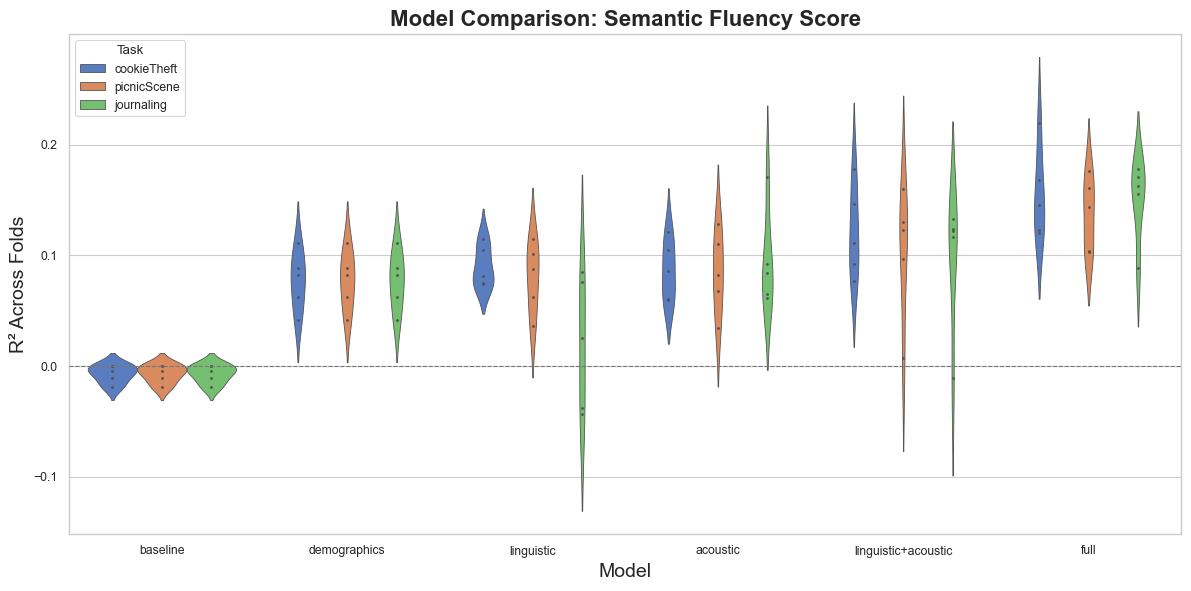

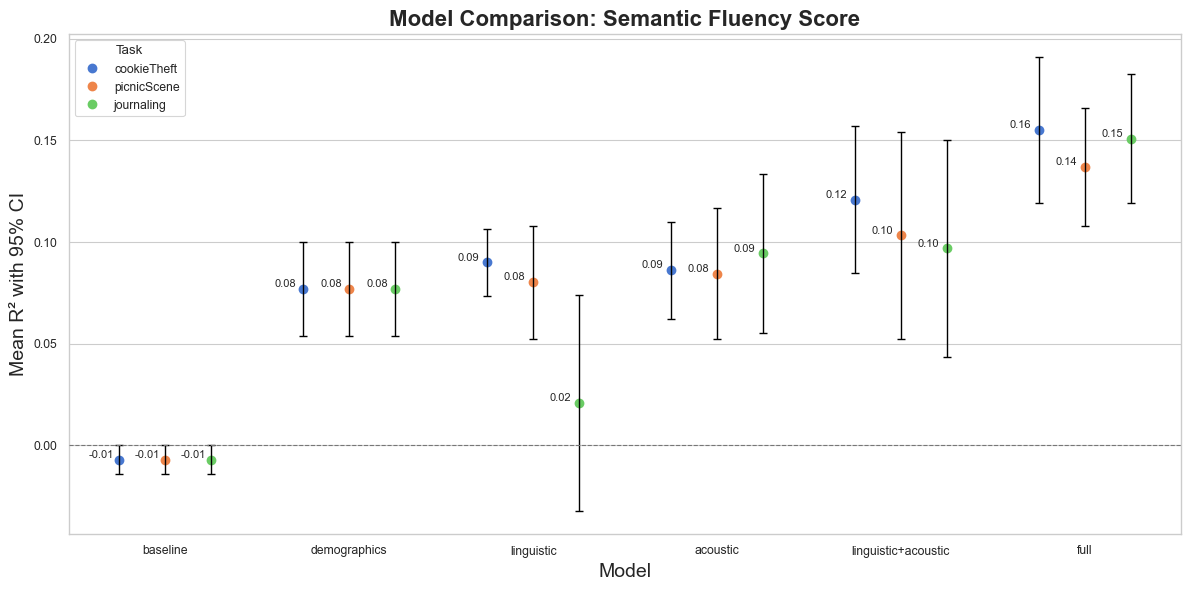

In [138]:
# plots
plot_model_task_violin(df_folds, metric="r2", target=target, model_to_plot=None, save_path=save_path, model_type_name=model_type_name)
plot_model_task_pointplot(summary_df, save_path=save_path, target=target, model_type_name=model_type_name)